# 🤖 Experiment: The "Blind Robot" (Qubit Rotation)

### The Concept
This is the "Hello World" of **Quantum Machine Learning**.
* **Classical ML:** You have a Neuron and a Weight ($w$). You multiply them ($w \cdot x$) to get an output.
* **Quantum ML:** You have a Qubit and a Rotation Angle ($\phi$). You rotate the qubit by that angle to get a new state.

### Our Goal
1.  **Start:** Qubit pointing **UP** (State $|0\rangle$, Expectation Value +1).
2.  **Target:** Qubit pointing **DOWN** (State $|1\rangle$, Expectation Value -1).
3.  **Constraint:** We will **not** manually set the angle to $\pi$ (180°). We will force the computer to learn it using **Gradient Descent**.

### The Math
* **Loss Function:** We measure the expectation value of Pauli-Z.
    * Result ranges from +1 (Bad) to -1 (Perfect).
    * Therefore, minimizing the circuit output *is* minimizing the loss.

In [2]:
import pennylane as qml
from pennylane import numpy as np  # <--- CRITICAL: Enables Autograd

# 1. Define the Device
# We only need 1 wire (qubit) because we are training a single unit.
dev = qml.device("default.qubit", wires=1)

print("Device ready. Autograd enabled.")

Device ready. Autograd enabled.


### 2. Defining the Parametric Circuit
In classical ML, this would be your "Model Definition" (like `nn.Linear`).
Here, our "layer" is an **RX Gate** (Rotation around X-axis).
* **Input:** A parameter `params` (the angle).
* **Operation:** Rotate the qubit.
* **Output:** Measure where the qubit is pointing (Pauli Z axis).

In [3]:
# ------------------------------------------------------------------
# STEP 2: DEFINING THE QUANTUM CIRCUIT (THE MODEL)
# ------------------------------------------------------------------

@qml.qnode(dev)
def circuit(params):
    """
    Arguments:
    params -- A single number (angle) representing our 'weight' or 'rotation amount'.
    """
    
    # 1. The Operation (The Layer)
    # We apply a rotation around the X-axis.
    # If params = 0, nothing happens.
    # If params = 3.14 (Pi), it flips completely.
    qml.RX(params, wires=0)
    
    # 2. The Measurement (The Output)
    # We measure the 'PauliZ' value.
    # - If the Qubit is UP (|0>), the result is +1.
    # - If the Qubit is DOWN (|1>), the result is -1.
    return qml.expval(qml.PauliZ(0))

print("Quantum Circuit (Model) defined.")

Quantum Circuit (Model) defined.


### 3. Pre-Training Check
Before training, we initialize the parameter with a random small value.
We expect the output to be close to **+1.0** (Failure/Up), because we haven't trained it yet.

In [4]:
# ------------------------------------------------------------------
# STEP 3: INITIAL GUESS
# ------------------------------------------------------------------

# We create a variable 'phi' (our weight).
# We set it to 0.05 radians (very small rotation).
# 'requires_grad=True' tells Python: "Watch this variable! We are going to train it."
phi = np.array(0.05, requires_grad=True)

# Run the circuit with this initial guess
output = circuit(phi)

print(f"Initial Angle: {phi:.4f} radians")
print(f"Model Output:  {output:.4f}")

print("\n--- Interpretation ---")
print("Target Output: -1.0 (Down)")
print(f"Current Output: {output:.4f} (Still pointing mostly Up)")
print("Conclusion: The model is untrained.")

Initial Angle: 0.0500 radians
Model Output:  0.9988

--- Interpretation ---
Target Output: -1.0 (Down)
Current Output: 0.9988 (Still pointing mostly Up)
Conclusion: The model is untrained.


### 4. Defining the Cost Function
In ML, we minimize a "Cost" or "Loss".
Since our circuit outputs:
* **+1** for failure
* **-1** for success

We can use the circuit output directly as our Cost. If we minimize the output, we maximize success.

In [5]:
# ------------------------------------------------------------------
# STEP 4: DEFINING THE COST FUNCTION
# ------------------------------------------------------------------

def cost(x):
    """
    The Cost Function is what the optimizer tries to minimize.
    Here, we simply want the circuit output (Expectation of PauliZ) 
    to be as low as possible (-1).
    """
    return circuit(x)

# Let's check the cost with our initial random parameter
print(f"Initial Cost (Loss): {cost(phi):.4f}")

Initial Cost (Loss): 0.9988


### 5. The Training Loop (Gradient Descent)
Now we act like Data Scientists.
1.  **Optimizer:** We use Gradient Descent (just like in Neural Nets).
2.  **Learning Rate:** 0.4 (How big the steps are).
3.  **Steps:** 100 iterations.

In [7]:
# ------------------------------------------------------------------
# STEP 5: TRAINING THE QUANTUM CIRCUIT
# ------------------------------------------------------------------

# 1. Select the Optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4)

# 2. The Training Loop
steps = 100
params = phi  # Start with our random guess

print("--- Starting Training ---")
cost_history = []

for i in range(steps):
    # UPDATE STEP:
    # The optimizer calculates the gradient and updates 'params'
    # params_new = params_old - (learning_rate * gradient)
    params = opt.step(cost, params)
    
    # Record history for plotting
    current_cost = cost(params)
    cost_history.append(current_cost)
    
    # Print progress every 20 steps
    if (i + 1) % 20 == 0:
        print(f"Step {i+1}: Angle = {params:.4f} rad, Cost = {current_cost:.4f}")

print("\n--- Training Complete ---")
print(f"Final Angle: {params:.4f} radians")
print(f"Target Angle: {np.pi:.4f} radians (Pi)")

--- Starting Training ---
Step 20: Angle = 3.1203 rad, Cost = -0.9998
Step 40: Angle = 3.1416 rad, Cost = -1.0000
Step 60: Angle = 3.1416 rad, Cost = -1.0000
Step 80: Angle = 3.1416 rad, Cost = -1.0000
Step 100: Angle = 3.1416 rad, Cost = -1.0000

--- Training Complete ---
Final Angle: 3.1416 radians
Target Angle: 3.1416 radians (Pi)


### 6. Visualizing the Learning Curve
Let's verify that the loss actually went down over time.
This plot is the proof that your Quantum Circuit "learned" the task.

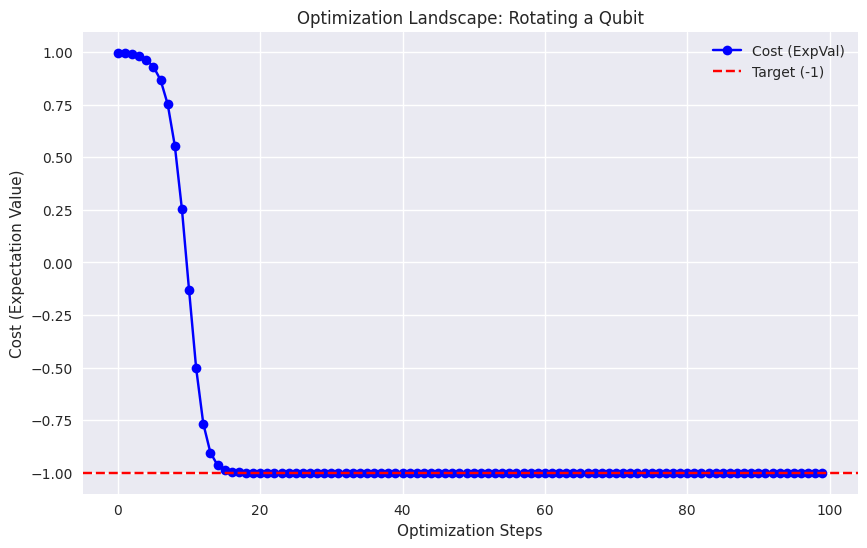

In [10]:
# ------------------------------------------------------------------
# STEP 6: PLOTTING THE RESULTS
# ------------------------------------------------------------------
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10, 6))

# Plot the Cost History
plt.plot(cost_history, 'b-o', label='Cost (ExpVal)')

# Add labels
plt.title("Optimization Landscape: Rotating a Qubit")
plt.xlabel("Optimization Steps")
plt.ylabel("Cost (Expectation Value)")
plt.axhline(-1, color='r', linestyle='--', label="Target (-1)")
plt.legend()
plt.grid(True)
plt.show()